In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from keras import layers
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
dataset_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset'

In [5]:
img_with_tumor_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes'
img_without_tumor_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/no'

In [6]:
print('There are {} images with tumor'.format(len(img_with_tumor_dir)))

There are 60 images with tumor


In [7]:
print('There are {} images without tumor'.format(len(img_without_tumor_dir)))

There are 59 images without tumor


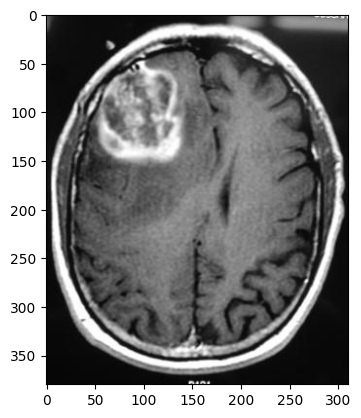

In [8]:
img1 = mpimg.imread('/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y15.jpg')
plt.imshow(img1)
plt.show()

In [9]:
img_height, img_width = 128, 128
batch_size = 32
epochs = 50
learning_rate = 0.0001

In [10]:
# Image data generator with rescaling
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% for validation
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.2,
    #width_shift_range=0.2, 
    #height_shift_range=0.2,  
    #brightness_range=[0.8, 1.2]  
)

# Training data generator
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Validation data generator
validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [11]:
print(train_generator.class_indices)

{'no': 0, 'yes': 1}


In [12]:
# load base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# Freeze the layers which you don't want to train
for layer in base_model.layers[-2:]:
    layer.trainable = False


# Functional API to build the model with adjusted regularization
inputs = tf.keras.Input(shape=(img_height, img_width, 3))

# VGG16 base model
x = base_model(inputs, training=False)

# Flatten the output of VGG16
x = layers.Flatten()(x)

x = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0002))(x)  # Dense layer with L2 regularization
x = layers.Dropout(0.4)(x)  # Dropout layer

# Output layer
outputs = layers.Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs, outputs)




In [14]:
# Define the ReduceLROnPlateau scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=3, 
                              min_lr=1e-7, 
                              verbose=1)

In [15]:
# Define the ExponentialDecay scheduler
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

In [16]:
# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [17]:
# Option 1: Use RMSprop
rms_opt = RMSprop(learning_rate=learning_rate)

# Option 2: Use SGD with momentum
sgd_opt = SGD(learning_rate=learning_rate, momentum=0.9)

# Option 3: Use Adam 
adam_opt = Adam(learning_rate=learning_rate)

In [18]:
# Compile the model
model.compile(optimizer=adam_opt, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 14,452,545 (55.13 MB)

 Non-trainable params: 2,359,808 (9.00 MB)

In [19]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 74s 10s/step - accuracy: 0.5926 - loss: 0.7586 - val_accuracy: 0.8000 - val_loss: 0.6060 - learning_rate: 1.0000e-04
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 68s 10s/step - accuracy: 0.6682 - loss: 0.7004 - val_accuracy: 0.8000 - val_loss: 0.5658 - learning_rate: 1.0000e-04
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 68s 10s/step - accuracy: 0.6729 - loss: 0.6626 - val_accuracy: 0.7200 - val_loss: 0.5575 - learning_rate: 1.0000e-04
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 68s 10s/step - accuracy: 0.7937 - loss: 0.5630 - val_accuracy: 0.6600 - val_loss: 0.6213 - learning_rate: 1.0000e-04
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 68s 10s/step - accuracy: 0.7933 - loss: 0.5589 - val_accuracy: 0.6800 - val_loss: 0.5670 - learning_rate: 1.0000e-04
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 69s 10s/step - accuracy: 0.8414 - loss: 0.4415 - val_accuracy: 0.7600 - val_loss: 0.4835 - learning_rate: 1.0000e-04
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 69s 10s/step - accuracy: 0.8072 - loss: 0.5247 - val_accu

In [20]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9688 - loss: 0.1691
Validation Loss: 0.16914838552474976
Validation Accuracy: 0.96875


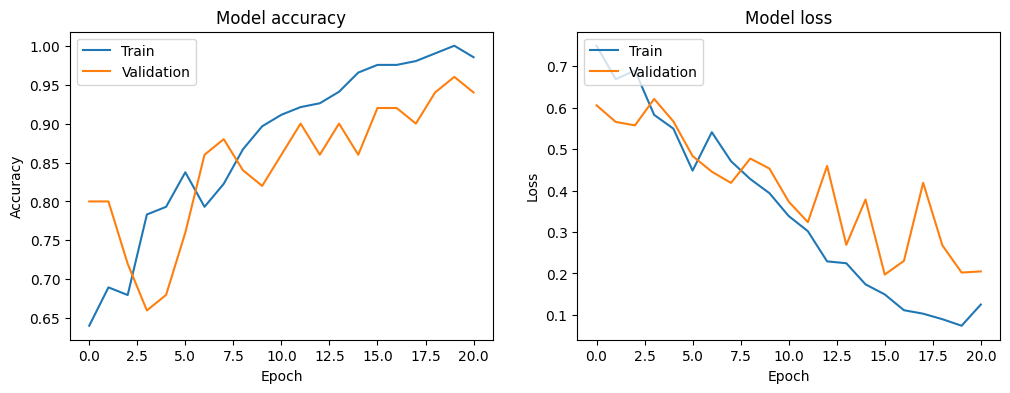

In [21]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [22]:
# Example function to predict tumor presence
def predict_tumor(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    if prediction[0] > 0.5:
        print("Tumor detected.")
    else:
        print("No tumor detected.")